In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import re
import arviz as az




In [2]:
df = pd.read_csv('../data/modeling_data.csv')
pd.set_option('display.max_columns', None)

#for the time being fill na with 0 
# df = df.fillna(0)
df.head()

C:\Users\ksbuf\AppData\Local\Temp\ipykernel_29356\1077962401.py:1: DtypeWarning: Columns (187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/modeling_data.csv')


,student_number,ac_ind,overall_gpa,days_attended,days_absent,school_membership,percent_days_attended,is_one_percent_y,extended_school_year_y,regular_percent_1.0,regular_percent_2.0,regular_percent_3.0,environment_h,environment_r,environment_v,gender_f,gender_m,gender_u,ethnicity_y,amerindian_alaskan_y,asian_y,black_african_amer_y,hawaiian_pacific_isl_y,white_y,migrant_y,military_child_y,refugee_student_y,gifted_y,services_504_y,immigrant_y,passed_civics_exam_y,reading_intervention_y,home_status_0,home_status_1,home_status_3,home_status_2,home_status_4,home_status_5,hs_complete_status_ao,hs_complete_status_ct,hs_complete_status_do,hs_complete_status_gc,hs_complete_status_gg,hs_complete_status_gq,hs_complete_status_gr,hs_complete_status_rt,hs_complete_status_nan,part_time_home_school_h,part_time_home_school_s,part_time_home_school_nan,part_time_home_school_p,tribal_affiliation_g,tribal_affiliation_n,tribal_affiliation_o,tribal_affiliation_p,tribal_affiliation_nan,tribal_affiliation_s,tribal_affiliation_u,limited_english_f,limited_english_n,limited_english_o,limited_english_y,limited_english_nan,ell_instruction_type_esl,ell_instruction_type_nan,ell_instruction_type_imt,ell_instruction_type_sei,ell_native_language_afr,ell_native_language_amh,ell_native_language_chi,ell_native_language_cmn,ell_native_language_cpe,ell_native_language_cus,ell_native_language_dan,ell_native_language_eng,ell_native_language_fre,ell_native_language_ger,ell_native_language_hat,ell_native_language_hin,ell_native_language_ind,ell_native_language_ita,ell_native_language_jpn,ell_native_language_khm,ell_native_language_kor,ell_native_language_mah,ell_native_language_nav,ell_native_language_nub,ell_native_language_por,ell_native_language_rus,ell_native_language_slv,ell_native_language_smo,ell_native_language_som,ell_native_language_spa,ell_native_language_tgl,ell_native_language_ton,ell_native_language_ukr,ell_native_language_vie,ell_native_language_nan,ell_native_language_ara,ell_native_language_fin,ell_native_language_nor,ell_native_language_swe,ell_native_language_tha,ell_native_language_yue,ell_native_language_arm,ell_native_language_bur,ell_native_language_cpp,ell_native_language_fil,ell_native_language_kar,ell_native_language_lao,ell_native_language_lin,ell_native_language_nep,ell_native_language_pol,ell_native_language_tam,ell_native_language_ase,ell_native_language_prs,ell_native_language_swa,ell_native_language_tur,ell_native_language_wol,ell_parent_language_afr,ell_parent_language_amh,ell_parent_language_chi,ell_parent_language_cmn,ell_parent_language_eng,ell_parent_language_fre,ell_parent_language_ger,ell_parent_language_hin,ell_parent_language_jpn,ell_parent_language_khm,ell_parent_language_kor,ell_parent_language_mah,ell_parent_language_nav,ell_parent_language_nub,ell_parent_language_por,ell_parent_language_rus,ell_parent_language_smo,ell_parent_language_som,ell_parent_language_spa,ell_parent_language_tgl,ell_parent_language_ton,ell_parent_language_vie,ell_parent_language_nan,ell_parent_language_ara,ell_parent_language_ita,ell_parent_language_swe,ell_parent_language_tha,ell_parent_language_yue,ell_parent_language_alb,ell_parent_language_arm,ell_parent_language_lao,ell_parent_language_nep,ell_parent_language_pol,ell_parent_language_tam,ell_parent_language_ase,ell_parent_language_bur,ell_parent_language_prs,ell_parent_language_swa,ell_parent_language_ukr,ell_parent_language_per,ell_parent_language_wol,read_grade_level_y,exit_code_11,exit_code_do,exit_code_ex,exit_code_fe,exit_code_ge,exit_code_he,exit_code_og,exit_code_t1,exit_code_t2,exit_code_tc,exit_code_td,exit_code_th,exit_code_tn,exit_code_to,exit_code_tp,exit_code_tr,exit_code_ts,exit_code_un,exit_code_wd,exit_code_wm,exit_code_nan,exit_code_ae,exit_code_de,ell_entry_date,entry_date,first_enroll_us,test_date,composite_score,english_score,math_score,reading_score,science_score,writing_score,teacher_10,teacher_769,teacher_891,teacher_1008,teacher_1431,teacher_1689,teacher_1810,teacher_2195,teac

In [ ]:
for col in df.columns:
    na_count = df[col].isna().sum()
    if na_count > 0:
        print(f"Column '{col}' has {na_count} missing values.")


1272565


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18474 entries, 0 to 18473
Columns: 1540 entries, student_number to school_710
dtypes: float64(1439), int64(99), object(2)
memory usage: 217.1+ MB


In [4]:
# Create ELL column: 1 if an ELL student , 0 if native English speaker
df["ell_status"] = df[["limited_english_y", "limited_english_o", 'limited_english_f']].max(axis=1)

#create the disability status column, if any of "regular_percent_1.0", "regular_percent_2.0", "regular_percent_3.0" show one then disability status = 1 else 0
df["disability_status"] = df[["regular_percent_1.0", "regular_percent_2.0", 'regular_percent_3.0']].max(axis=1)


In [5]:
# Create a column for the four groups
df["ell_dis_group"] = (
    df["ell_status"].astype(str) + "_" + df["disability_status"].astype(str)
)

# Map it to meaningful labels
group_mapping = {
    "1_1": "ELL with Disability",
    "1_0": "ELL without Disability",
    "0_1": "Non-ELL with Disability",
    "0_0": "Non-ELL without Disability",
}
df["ell_dis_group"] = df["ell_dis_group"].map(group_mapping)

In [6]:
df["ell_dis_group"].value_counts()


ell_dis_group
Non-ELL without Disability    15666
Non-ELL with Disability        1517
ELL without Disability         1066
ELL with Disability             225
Name: count, dtype: int64

In [7]:
#This will assign a unique integer (0, 1, 2, 3) to each of the four groups.

df["ELL_Disability_Index"] = df["ell_dis_group"].astype("category").cat.codes
group_labels = dict(enumerate(df["ell_dis_group"].astype("category").cat.categories))


In [8]:
# Set the sample fraction for the subset data
sample_fraction = 0.1

#establish the subset DF to test to see if the model is set up correctly
subset_df = df[['ac_ind', 'overall_gpa', 'teacher_218966', 'english_score', 'ell_dis_group', 'ELL_Disability_Index']]

# Stratified sampling
subset_df = subset_df.groupby("ell_dis_group", group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=42))

# Check the new group distribution
print(subset_df['ell_dis_group'].value_counts())

ell_dis_group
Non-ELL without Disability    1567
Non-ELL with Disability        152
ELL without Disability         107
ELL with Disability             22
Name: count, dtype: int64


C:\Users\ksbuf\AppData\Local\Temp\ipykernel_29356\2107255324.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = subset_df.groupby("ell_dis_group", group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=42))


# What the model does:

1. Varying Intercepts (a):

    - Each group (ELL with Disability, Non-ELL without Disability etc.) has its own baseline.

2. Varying Slopes (b):

    - Each predictor has a different effect for each group.
For example, b[0,0] is the coefficient of Predictor 0 for Group 0, and b[3,1] is for Predictor 1 in Group 3.

3. Group-Specific Predictions:

    - The line logit_p = a[group_idx] + pm.math.sum(b[group_idx] * X, axis=1) applies the correct intercept and slope for each observation based on its group.

In [9]:
# Convert categorical group column to an array
group_idx = subset_df["ELL_Disability_Index"].astype('category').cat.codes.values
num_groups = subset_df["ELL_Disability_Index"].nunique()

#columns to drop
col_drop = ['ac_ind', 'ell_dis_group', 'ELL_Disability_Index']

# Predictor variables 
X = subset_df.drop(columns = col_drop).values
num_predictors = X.shape[1]

# Outcome variable
y = subset_df["ac_ind"].values 

In [10]:
#set up and create the model

with pm.Model() as model:
    # Group-level intercepts (varying by ELL-Disability group)
    mu_a = pm.Normal("mu_a", mu=0, sigma=1)                   # Hyperprior for intercept mean
    sigma_a = pm.Exponential("sigma_a", 1)                    # Hyperprior for variance
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=num_groups)  # Varying intercepts for groups

    # Group-level slopes (varying slopes for each predictor within each group)
    mu_b = pm.Normal("mu_b", mu=0, sigma=1, shape=num_predictors)     # Hyperprior for slope means
    sigma_b = pm.Exponential("sigma_b", 1, shape=num_predictors)      # Hyperprior for slope variances
    
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=(num_groups, num_predictors))  # Varying slopes for each predictor

    # Linear predictor (logit model)
    logit_p = a[group_idx] + pm.math.sum(b[group_idx] * X, axis=1)

    # Sigmoid transformation to convert log-odds to probability
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Likelihood (Bernoulli response)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)




KeyboardInterrupt: 

In [ ]:
# Summary of the trace (shows means, HDIs, etc.)
summary = az.summary(trace, hdi_prob=0.95)  # 95% credible intervals

In [ ]:
# map out our predictor names and group names for better interpretability
predictor_names = subset_df.drop(columns = col_drop, axis = 1).columns.tolist()

# Map group indices to group names
group_labels = {
    0: "ELL with Disability",
    1: "ELL without Disability",
    2: "Non-ELL with Disability",
    3: "Non-ELL without Disability"
}

In [ ]:
# Rename intercepts for clarity
summary = summary.rename(index={f"a[{i}]": f"Intercept: {group_labels[i]}" for i in range(len(group_labels))})

# Rename slopes with format: "group_number-predictor_name"
for i in range(len(group_labels)):
    for j, predictor_name in enumerate(predictor_names):
        summary = summary.rename(index={f"b[{i}, {j}]": f"Group {i} - {predictor_name}"})


In [ ]:
summary[:20]


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,-1.655,1.203,-3.618,0.587,0.175,0.135,54.0,671.0,1.05
Intercept: ELL with Disability,-6.105,1.509,-8.967,-3.022,0.039,0.028,1496.0,1585.0,1.04
Intercept: ELL without Disability,-5.904,1.132,-8.297,-4.147,0.184,0.131,35.0,115.0,1.07
Intercept: Non-ELL with Disability,-5.606,1.130,-7.725,-3.502,0.062,0.046,434.0,1795.0,1.01
Intercept: Non-ELL without Disability,-6.727,0.511,-7.778,-5.785,0.028,0.020,362.0,1161.0,1.01
mu_b[0],1.012,0.460,0.001,1.621,0.112,0.081,31.0,64.0,1.08
mu_b[1],1.450,0.467,0.327,2.246,0.015,0.010,1195.0,1712.0,1.01
mu_b[2],0.168,0.055,0.073,0.276,0.004,0.003,89.0,699.0,1.04
Group 0 - overall_gpa,1.093,0.442,0.172,1.945,0.010,0.007,2123.0,2055.0,1.07
Group 0 - teacher_218966,1.175,0.766,-0.645,2.306,0.032,0.023,465.0,1737.0,1.02


### ***add in prior and posterior predictive checks or check to see if they are built into pymc

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

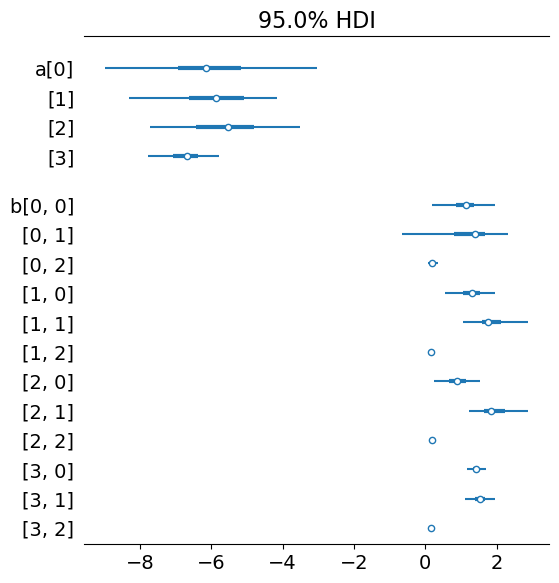

In [ ]:
az.plot_forest(trace, var_names=["a", "b"], combined=True, hdi_prob=0.95)


In [ ]:
# Convert summary to DataFrame
summary_df = summary.reset_index().rename(columns={"index": "Parameter"})

# Save to CSV
summary_df.to_csv("data/model_coefficients.csv", index=False)


OSError: Cannot save file into a non-existent directory: 'data'